<a href="https://colab.research.google.com/github/retrouvailles00/cs6120/blob/main/CS6120_ASSIGNMENT2_RuiLiu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install sentencepiece
import os

!pip install transformers
from transformers import pipeline

import json,requests
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 117.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 92.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.4 MB/s eta 0:00:00


In [46]:
def get_data_by_author_name(author_name):
  url = 'https://api.semanticscholar.org/graph/v1/author/search?query=' + str(author_name) + '&fields=name,citationCount,papers,papers.citationCount'
  j = requests.get(url).json()
  if j['data'] is not None:
    return j['data']

In [47]:
def citations(rec): return rec['citationCount']

def get_sorted_author_id(data):
  sorted_authorIds = [d['authorId'] for d in sorted(data, key=citations, reverse=True)]
  if len(sorted_authorIds) > 3:
    return sorted_authorIds[0:3]
  return sorted_authorIds

In [48]:
data = get_data_by_author_name("Noah Smith")

In [49]:
author_ids = get_sorted_author_id(data)

In [50]:
def get_paper_ids(author_ids):
  all_paper_ids = []
  for author_id in author_ids:
    paper = [x['papers'] for x in data if x["authorId"]==author_id]
    if len(paper) != 0:
      paper_ids = [paper['paperId'] for paper in sorted(paper[0], key=citations, reverse=True)]
      if len(paper_ids) > 4:
        paper_ids = paper_ids[0:4]
      all_paper_ids.append(paper_ids)
  return all_paper_ids

all_paper_ids = get_paper_ids(author_ids)

In [51]:
def get_titles_by_paper_id(paper_id):
  url = 'https://api.semanticscholar.org/graph/v1/paper/' + str(paper_id) + '?fields=title'
  j = requests.get(url).json()
  if j['title'] is not None:
    return j['title']

In [52]:
def get_titles(all_paper_ids):
  texts = []
  for paper_ids in all_paper_ids:
    for paper_id in paper_ids:
      title = get_titles_by_paper_id(paper_id)
      if title is None:
        continue
      else:
        texts.append(title)
  return texts

In [53]:
titles = get_titles(all_paper_ids)

In [54]:
def get_abstracts_by_paper_id(paper_id):
  url = 'https://api.semanticscholar.org/graph/v1/paper/' + str(paper_id) + '?fields=abstract'
  j = requests.get(url).json()
  if j['abstract'] is not None:
    return j['abstract']

def get_abstracts(all_paper_ids):
  texts = []
  for paper_ids in all_paper_ids:
    for paper_id in paper_ids:
      abstract = get_abstracts_by_paper_id(paper_id)
      if abstract is None:
        continue
      else:
        texts.append(abstract)
  return texts

In [55]:
abstracts = get_abstracts(all_paper_ids)

English - Chinese - English

In [60]:
en_zh_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-zh")
zh_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-zh-en")

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [61]:
en_fr_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr")
fr_en_translator = pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")

In [62]:
def translate_en_zh_en(input):
  translated_context = []
  for context in input:
    context = en_zh_translator(context)
    if context is not None:
      translated_context.append(zh_en_translator(context[0]['translation_text'])[0]['translation_text'])
  return translated_context

In [63]:
def translate_en_fr_en(input):
  translated_context = []
  for context in input:
    context = en_fr_translator(context)
    if context is not None:
      translated_context.append(en_fr_translator(context[0]['translation_text'])[0]['translation_text'])
  return translated_context

In [64]:
def text_to_specter(s, model="allenai/specter2_base"):
  pipe = pipeline("feature-extraction", model=model)
  return pipe(s, return_tensors = "pt")[:,0,:].detach().numpy().reshape(-1)

In [65]:
def get_specters(input):
  specters = []
  for text in input:
    specter = text_to_specter(text).reshape(-1, 1)
    specters.append(specter)
  specters = np.array(specters).reshape(len(input), -1)
  return specters


In [66]:
def plot_cossim(specters):
  sim = cosine_similarity(specters)
  plt.imshow(sim)
  plt.colorbar()

In [67]:
##untranslated specters
titles_specters_en = get_specters(titles)
abstracts_specters_en = get_specters(abstracts)

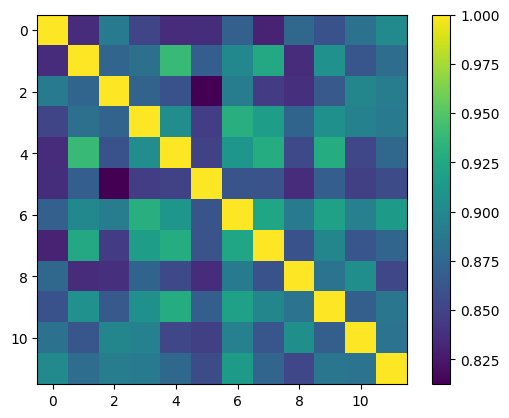

In [68]:
##plot for untranslated titles specters
plot_cossim(titles_specters_en)

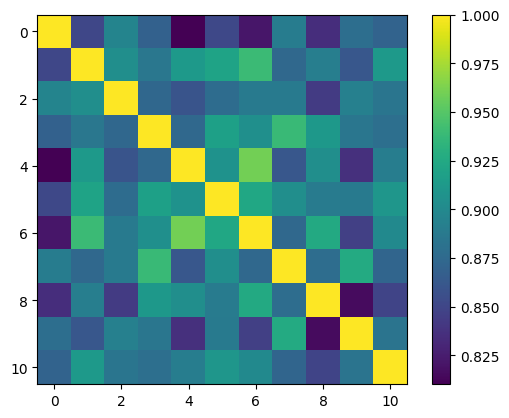

In [69]:
##plot for untranslated abstracts specters
plot_cossim(abstracts_specters_en)

In [70]:
translated_titles_zh = translate_en_zh_en(titles)
translated_titles_specters_zh = get_specters(translated_titles_zh)

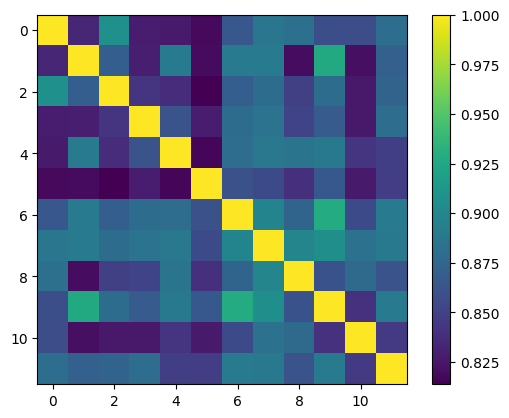

In [71]:
##plot for untranslated thru Chinese titles specters
plot_cossim(translated_titles_specters_zh)

{'whiskers': [<matplotlib.lines.Line2D at 0x7a267caba800>,
 'caps': [<matplotlib.lines.Line2D at 0x7a267cabad40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a267caba560>,
 'medians': [<matplotlib.lines.Line2D at 0x7a267cabb280>,
 'fliers': [<matplotlib.lines.Line2D at 0x7a267cabb520>,
 'means': []}

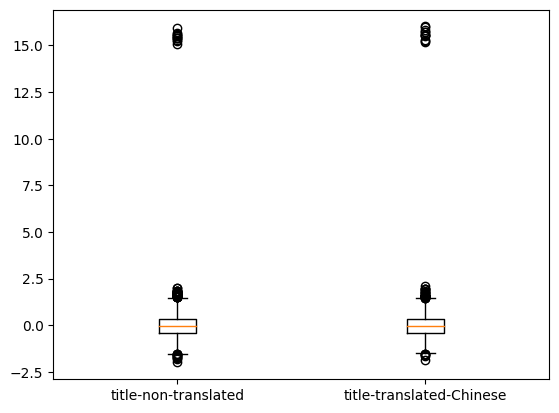

In [72]:
#box plot titles untranslated vs translate thru Chinese
plt.boxplot([titles_specters_en.reshape(-1), translated_titles_specters_zh.reshape(-1)], labels=["title-non-translated", "title-translated-Chinese"])

In [73]:
translated_abstracts_zh = translate_en_zh_en(abstracts)
translated_abstracts_specters_zh = get_specters(translated_abstracts_zh)

Your input_length: 504 is bigger than 0.9 * max_length: 512. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


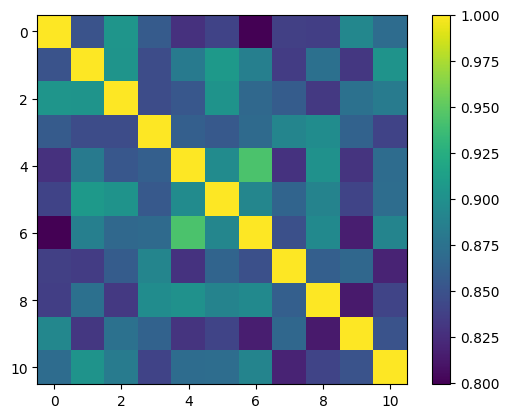

In [74]:
##plot for untranslated thru Chinese abstracts specters
plot_cossim(translated_abstracts_specters_zh)

{'whiskers': [<matplotlib.lines.Line2D at 0x7a267c5bf850>,
 'caps': [<matplotlib.lines.Line2D at 0x7a267c5bfd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a267c5bf5b0>,
 'medians': [<matplotlib.lines.Line2D at 0x7a267c5f0310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7a267c5f05b0>,
 'means': []}

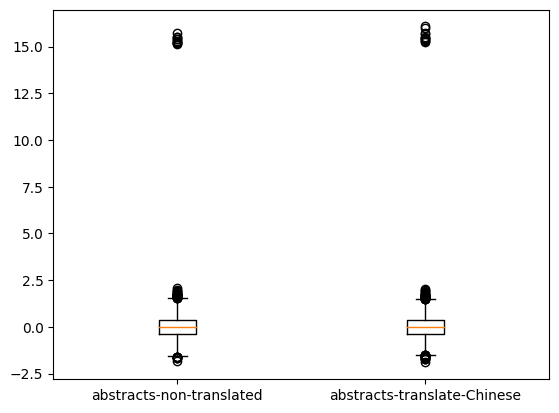

In [75]:
#box plot abstracts untranslated vs translate thru Chinese
plt.boxplot([abstracts_specters_en.reshape(-1), translated_abstracts_specters_zh.reshape(-1)], labels=["abstracts-non-translated", "abstracts-translate-Chinese"])

English - French - English

In [81]:
translated_titles_fr = translate_en_fr_en(titles)
translated_titles_specters_fr = get_specters(translated_titles_fr)

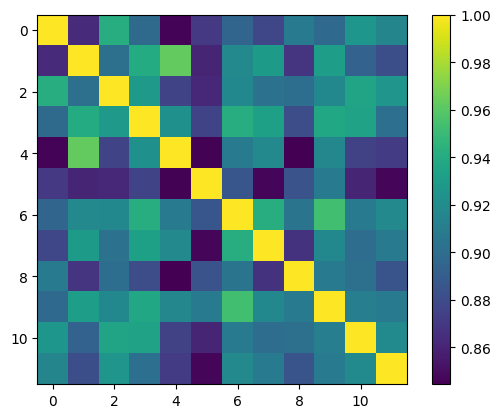

In [82]:
##plot for untranslated thru French titles specters
plot_cossim(translated_titles_specters_fr)

{'whiskers': [<matplotlib.lines.Line2D at 0x7a267c39bbb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7a267c39bd90>,
 'boxes': [<matplotlib.lines.Line2D at 0x7a267c662800>,
 'medians': [<matplotlib.lines.Line2D at 0x7a267c3e0310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7a267c3e05b0>,
 'means': []}

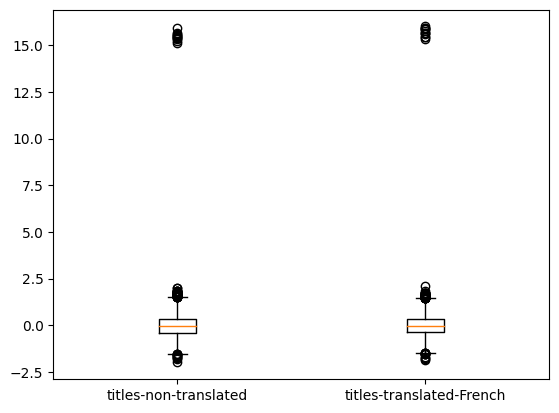

In [78]:
##box plot titles untranslated vs translate thru French
plt.boxplot([titles_specters_en.reshape(-1), translated_titles_specters_fr.reshape(-1)], labels=["titles-non-translated", "titles-translated-French"])

In [79]:
translated_abstracts_fr = translate_en_fr_en(abstracts)
translated_abstracts_specters_fr = get_specters(translated_abstracts_fr)

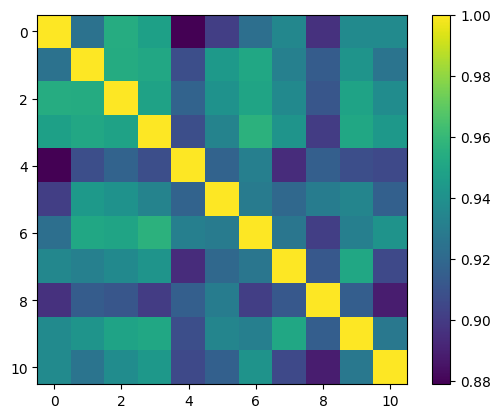

In [80]:
##plot for untranslated thru French abstracts specters
plot_cossim(translated_abstracts_specters_fr)

{'whiskers': [<matplotlib.lines.Line2D at 0x7cb39c8b6a40>,
 'caps': [<matplotlib.lines.Line2D at 0x7cb39c8b6f80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7cb39c8b67a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7cb39c8b74c0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7cb39c8b7760>,
 'means': []}

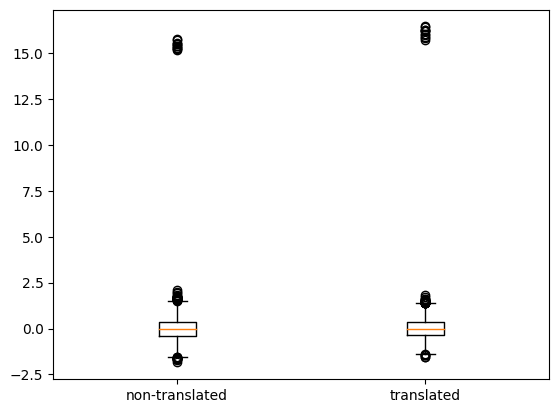

In [34]:
##box plot abstracts untranslated vs translate thru French
plt.boxplot([abstracts_specters_en.reshape(-1), translated_abstracts_specters_fr.reshape(-1)], labels=["abstracts-non-translated", "abstracts-translated-French"])

In [38]:
#Fill-Mask Task
sentence = "This is a test of the emergency broadcast system ."
#code reference: https://github.com/kwchurch/deepnet_examples/blob/main/pretrained/examples/HuggingFaceHub/Bertology/unmask/unmask.py
def maskify_MASK(tokens, i):
    left = right = []
    if i > 0:
        left = tokens[0:i]
    if i < len(tokens):
        right = tokens[(i+1):]
    return ' '.join(left) + ' [MASK] ' + ' '.join(right)

def maskify_mask(tokens, i):
    left = right = []
    if i > 0:
        left = tokens[0:i]
    if i < len(tokens):
        right = tokens[(i+1):]
    return ' '.join(left) + ' <mask> ' + ' '.join(right)
tokens = sentence.split()

In [39]:
def print_table(tokens, unmaster, mask):
  for i,token in enumerate(tokens):
    if (mask == 'MASK'):
      masked = maskify_MASK(tokens, i)
      candidates = ['%s|%0.3f' % (candidate['token_str'], candidate['score']) for candidate in unmasker(masked)]
      print(token + '\t' + ', '.join(candidates))
    else:
      masked = maskify_mask(tokens, i)
      candidates = ['%s|%0.3f' % (candidate['token_str'], candidate['score']) for candidate in unmasker(masked)]
      print(token + '\t' + ', '.join(candidates))

In [41]:
##BERT
unmasker = pipeline('fill-mask', model='bert-base-cased')
print_table(tokens, unmasker, 'MASK')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This	It|0.576, This|0.367, it|0.013, this|0.007, There|0.004
is	was|0.760, is|0.177, included|0.013, required|0.005, became|0.005
a	a|0.877, the|0.092, another|0.018, one|0.004, first|0.000
test	part|0.128, version|0.084, feature|0.081, variation|0.041, variant|0.040
of	of|0.911, for|0.039, on|0.016, in|0.008, against|0.005
the	the|0.544, an|0.414, any|0.005, their|0.005, this|0.005
emergency	radio|0.085, FM|0.073, digital|0.041, television|0.029, AM|0.024
broadcast	response|0.303, medical|0.050, management|0.049, lighting|0.043, warning|0.026
system	system|0.095, capability|0.047, power|0.047, technique|0.041, technology|0.032
.	.|0.988, ;|0.011, !|0.000, ?|0.000, :|0.000


In [42]:
#Roberta
unmasker = pipeline('fill-mask', model='roberta-base')
print_table(tokens, unmasker, '<mask>')

This	Here|0.506, This|0.352, Below|0.101, Following|0.016, Above|0.006
is	 is|0.952,  was|0.041,  shows|0.001,  represents|0.001,  includes|0.001
a	 a|0.961,  another|0.014,  the|0.010,  our|0.007,  my|0.002
test	 diagram|0.192,  schematic|0.132,  description|0.083,  map|0.056,  snapshot|0.045
of	 of|0.947,  for|0.017,  using|0.013,  on|0.006,  with|0.006
the	 the|0.686,  an|0.142,  our|0.132,  my|0.008,  their|0.007
emergency	 new|0.029,  standard|0.028,  Linux|0.022,  UDP|0.020,  radio|0.019
broadcast	 response|0.427,  alert|0.110,  management|0.046,  notification|0.035,  braking|0.022
system	 protocol|0.077,  capability|0.069,  system|0.056,  function|0.050,  signal|0.048
.	.|0.619, :|0.244,  :|0.039, .|0.012, ,|0.008


In [44]:
#Distilroberta
unmasker = pipeline('fill-mask', model='distilroberta-base')
print_table(tokens, unmasker, '<mask>')

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This	Below|0.213, This|0.194, Above|0.108, Here|0.066,  above|0.024
is	 is|0.778,  was|0.124,  represents|0.023,  includes|0.018,  constitutes|0.013
a	 a|0.736,  another|0.137,  our|0.017,  one|0.013,  an|0.011
test	 screenshot|0.129,  demonstration|0.107,  diagram|0.077,  snapshot|0.070,  sample|0.061
of	 of|0.696,  against|0.062,  using|0.062,  for|0.050,  involving|0.046
the	 our|0.379,  an|0.246,  the|0.208,  this|0.025,  its|0.019
emergency	 RSS|0.015,  TCP|0.014,  FM|0.014,  asynchronous|0.013,  automated|0.009
broadcast	 response|0.131,  braking|0.093,  management|0.071,  reporting|0.043,  dispatch|0.037
system	 protocol|0.127,  system|0.085,  capability|0.082,  format|0.050,  signal|0.034
.	.|0.205,  |0.116,  :|0.087, !|0.081, .|0.067
